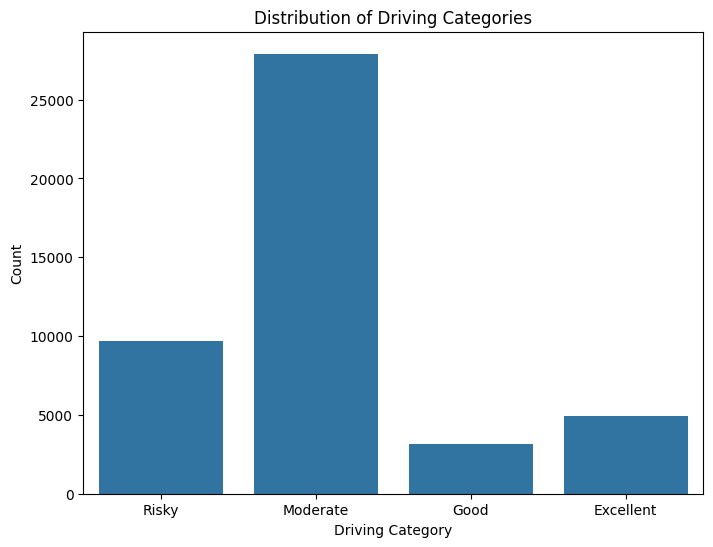

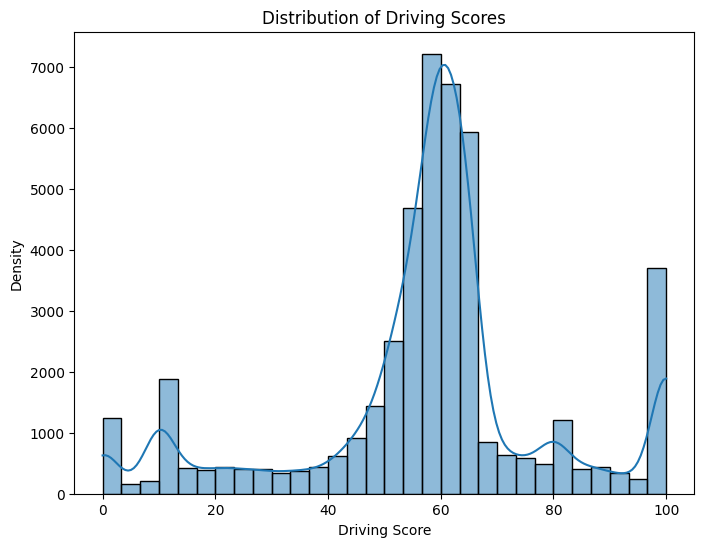

c:\Users\anush\OneDrive\Desktop\minor project\DriveIQ\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


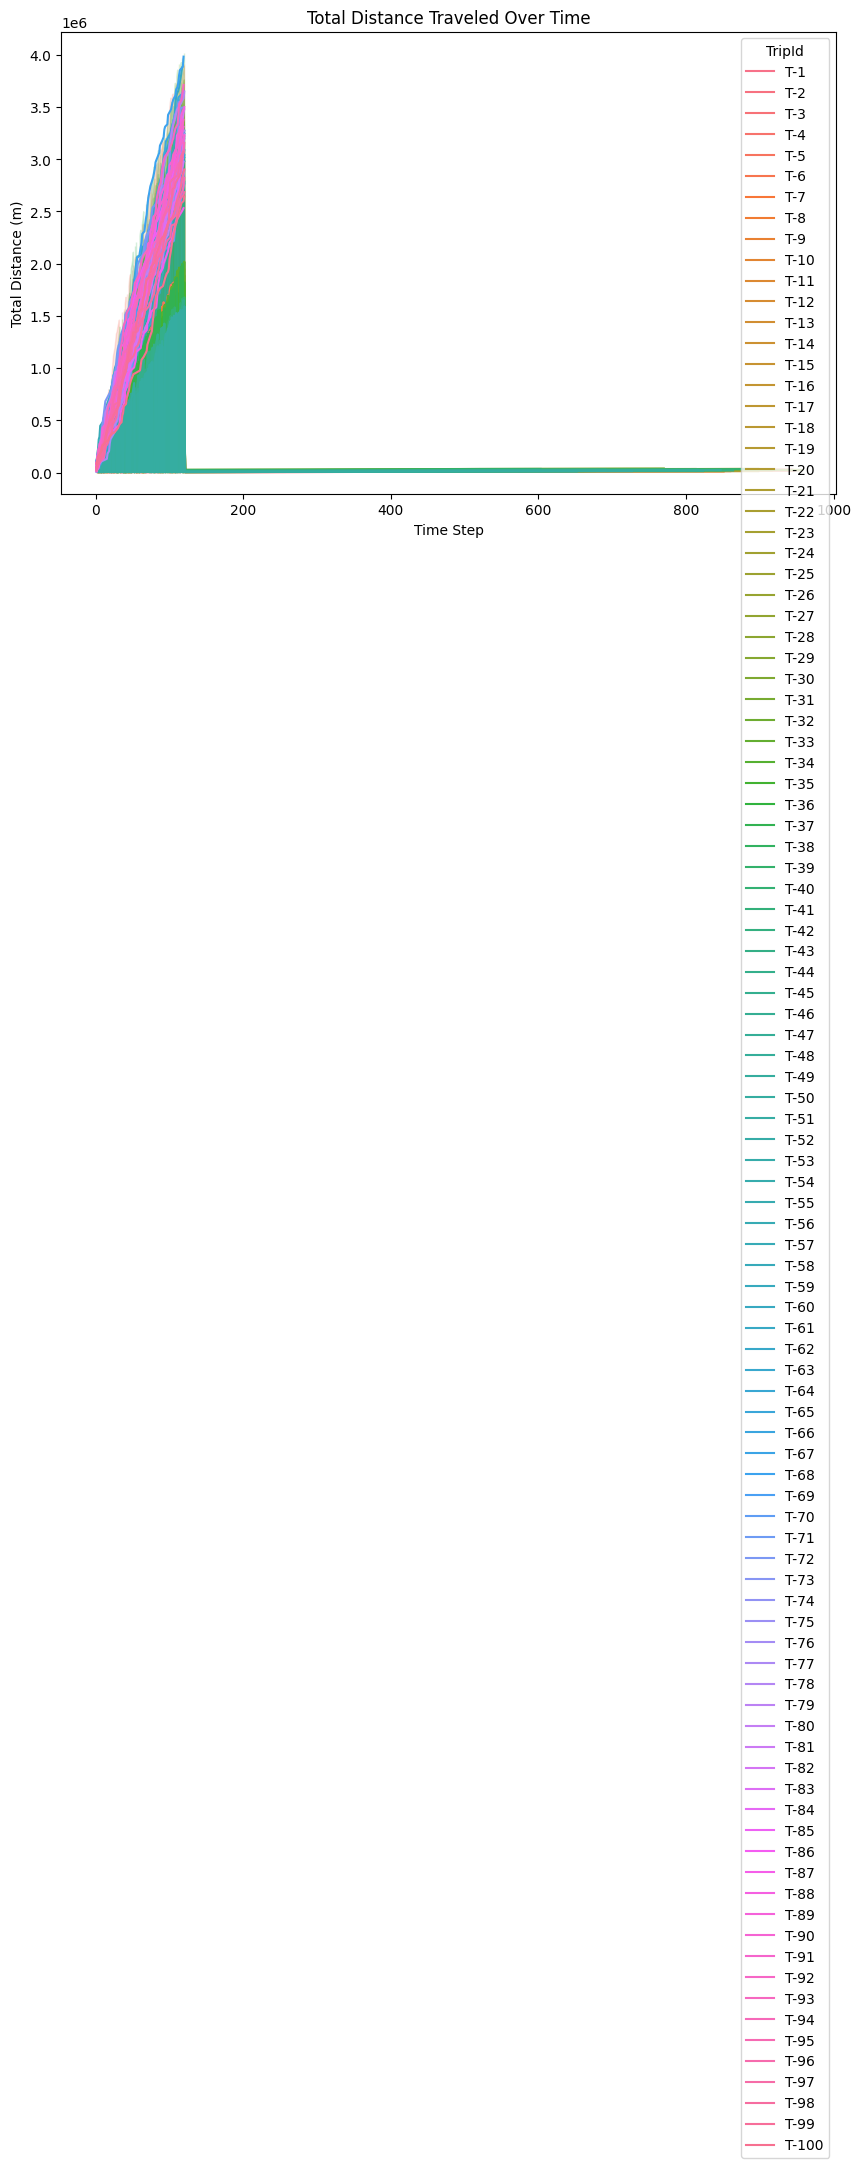

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2, degrees

# Ensure the 'data' directory exists
output_directory = 'data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the real and simulated GPS data
df_real = pd.read_csv('../data/driving_data.csv')
df_simulated = pd.read_csv('../data/simulated_driving_data.csv')

# Combine the real and simulated data
df = pd.concat([df_real, df_simulated], ignore_index=True)

# Ensure that Time_Step, Latitude, and Longitude are numeric
df['Time_Step'] = pd.to_numeric(df['Time_Step'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop any rows where numeric conversion failed
df = df.dropna(subset=['Time_Step', 'Latitude', 'Longitude'])

# Convert Speed from km/h to m/s
df['Speed(m/s)'] = df['Speed(km/h)'] * 0.27778

# Vectorized Haversine formula to calculate distance between two points
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    
    a = np.sin(d_lat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c * 1000  # Return distance in meters

# Calculate differences for time, latitude, and longitude
df['Time_Diff'] = df['Time_Step'].diff().fillna(0)

# Latitude and Longitude shifted by one row for distance calculation
df['Lat_Shifted'] = df['Latitude'].shift(1, fill_value=df['Latitude'].iloc[0])
df['Lon_Shifted'] = df['Longitude'].shift(1, fill_value=df['Longitude'].iloc[0])

# Vectorized distance calculation
df['Distance(m)'] = haversine_vectorized(df['Latitude'], df['Longitude'], df['Lat_Shifted'], df['Lon_Shifted'])

# Function to calculate Heading Change between two points
def calculate_heading_change(lat1, lon1, lat2, lon2):
    d_lon = lon2 - lon1
    y = sin(radians(d_lon)) * cos(radians(lat2))
    x = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(d_lon))
    return degrees(atan2(y, x))

# Calculate heading change based on latitude and longitude differences
df['Heading'] = df.apply(lambda row: calculate_heading_change(row['Lat_Shifted'], row['Lon_Shifted'], row['Latitude'], row['Longitude']), axis=1)
df['Heading_Change(degrees)'] = df['Heading'].diff().fillna(0)

# Filter out unrealistic speeds (over 150 km/h or ~41.67 m/s)
df = df[df['Speed(m/s)'] <= 41.67]

# Calculate Acceleration (m/s^2)
df['Acceleration(m/s^2)'] = df['Speed(m/s)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)

# Filter out unrealistic acceleration (over 10 m/s²)
df = df[df['Acceleration(m/s^2)'].between(-10, 10)]

# Calculate Jerk (m/s^3)
df['Jerk(m/s^3)'] = df['Acceleration(m/s^2)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)

# Braking Intensity (absolute negative acceleration)
df['Braking_Intensity'] = df['Acceleration(m/s^2)'].apply(lambda x: abs(x) if x < 0 else 0)

# Total distance traveled for each trip
df['Total_Distance(m)'] = df.groupby('TripId')['Distance(m)'].cumsum()

# Total trip duration (in seconds)
df['Trip_Duration(s)'] = df.groupby('TripId')['Time_Diff'].cumsum()

# Calculate driving score using weighted factors, including heading change
def calculate_driving_score(row):
    speed_score = max(1 - min(row['Speed(m/s)'] / 11.11, 1), 0)  # Higher speed reduces the score
    accel_score = max(1 - min(abs(row['Acceleration(m/s^2)']) / 2, 1), 0)  # Lower acceleration gives higher score
    jerk_score = max(1 - min(abs(row['Jerk(m/s^3)']) / 1.5, 1), 0)  # Lower jerk gives higher score
    braking_score = max(1 - min(row['Braking_Intensity'] / 2, 1), 0)  # Lower braking intensity increases score
    heading_score = max(1 - min(abs(row['Heading_Change(degrees)']) / 60, 1), 0)  # Lower heading changes are safer
    
    # Combine the factors into a score (weighted sum)
    score = (0.35 * speed_score + 0.2 * accel_score + 0.15 * jerk_score + 0.1 * braking_score + 0.2 * heading_score) * 100
    return score

df['Driving_Score'] = df.apply(calculate_driving_score, axis=1)

# Categorize driving based on the score
def categorize_driving_score(score):
    if score > 85:
        return 'Excellent'  # Very safe driving
    elif score > 70:
        return 'Good'       # Safe driving
    elif score > 50:
        return 'Moderate'   # Some risky behavior
    else:
        return 'Risky'      # Aggressive or risky driving

df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving_score)

# Save the processed data with scores and categories
df.to_csv('data/processed_data.csv', index=False)

### Visualization of Results

# 1. Distribution of Driving Categories
plt.figure(figsize=(8, 6))
sns.countplot(x='Driving_Category', data=df)
plt.title('Distribution of Driving Categories')
plt.xlabel('Driving Category')
plt.ylabel('Count')
plt.show()

# 2. Distribution of Driving Scores
plt.figure(figsize=(8, 6))
sns.histplot(df['Driving_Score'], kde=True, bins=30)
plt.title('Distribution of Driving Scores')
plt.xlabel('Driving Score')
plt.ylabel('Density')
plt.show()

# 3. Total Distance vs Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Time_Step', y='Total_Distance(m)', hue='TripId', data=df)
plt.title("Total Distance Traveled Over Time")
plt.xlabel("Time Step")
plt.ylabel("Total Distance (m)")
plt.show()
